In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 184)
(734160, 1)
validation
(101248, 184)
(101248, 1)
test
(100432, 184)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 878593 (3.35 MB)


Trainable params: 878593 (3.35 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:24 - loss: 0.1399 - STD: 9.5385e-05 - MAE: 0.3616

 7/74 [=>............................] - ETA: 0s - loss: 0.0381 - STD: 6.5198e-05 - MAE: 0.1511  

13/74 [====>.........................] - ETA: 0s - loss: 0.0338 - STD: 3.8870e-05 - MAE: 0.1462

19/74 [======>.......................] - ETA: 0s - loss: 0.0297 - STD: 2.8194e-05 - MAE: 0.1353

25/74 [=========>....................] - ETA: 0s - loss: 0.0251 - STD: 2.3873e-05 - MAE: 0.1217

31/74 [===========>..................] - ETA: 0s - loss: 0.0225 - STD: 2.1766e-05 - MAE: 0.1161

37/74 [==============>...............] - ETA: 0s - loss: 0.0204 - STD: 1.9869e-05 - MAE: 0.1099

42/74 [================>.............] - ETA: 0s - loss: 0.0193 - STD: 1.8445e-05 - MAE: 0.1056

48/74 [==================>...........] - ETA: 0s - loss: 0.0181 - STD: 1.7196e-05 - MAE: 0.1017

54/74 [====================>.........] - ETA: 0s - loss: 0.0171 - STD: 1.6443e-05 - MAE: 0.0990

60/74 [=======================>......] - ETA: 0s - loss: 0.0163 - STD: 1.5905e-05 - MAE: 0.0968

66/74 [=========================>....] - ETA: 0s - loss: 0.0157 - STD: 1.5426e-05 - MAE: 0.0948

72/74 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 1.5130e-05 - MAE: 0.0931

74/74 [==============================] - 3s 25ms/step - loss: 0.0150 - STD: 1.5084e-05 - MAE: 0.0927 - val_loss: 0.0086 - val_STD: 1.0844e-05 - val_MAE: 0.0720


Epoch 2/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0091 - STD: 1.3070e-05 - MAE: 0.0756

 7/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 1.3729e-05 - MAE: 0.0759

13/74 [====>.........................] - ETA: 0s - loss: 0.0093 - STD: 1.4585e-05 - MAE: 0.0758

20/74 [=======>......................] - ETA: 0s - loss: 0.0093 - STD: 1.5478e-05 - MAE: 0.0757

26/74 [=========>....................] - ETA: 0s - loss: 0.0093 - STD: 1.6114e-05 - MAE: 0.0757

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.6829e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.7565e-05 - MAE: 0.0755

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.8277e-05 - MAE: 0.0755

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.9047e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.9884e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0836e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1931e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.3054e-05 - MAE: 0.0754

74/74 [==============================] - 1s 10ms/step - loss: 0.0092 - STD: 2.3054e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 2.8855e-05 - val_MAE: 0.0715


Epoch 3/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0093 - STD: 3.7052e-05 - MAE: 0.0759

 7/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 3.8050e-05 - MAE: 0.0755

14/74 [====>.........................] - ETA: 0s - loss: 0.0093 - STD: 3.9538e-05 - MAE: 0.0757

20/74 [=======>......................] - ETA: 0s - loss: 0.0092 - STD: 4.1071e-05 - MAE: 0.0756

26/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 4.2584e-05 - MAE: 0.0754

32/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 4.4201e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 4.5898e-05 - MAE: 0.0755

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 4.7528e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 4.9332e-05 - MAE: 0.0753

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 5.1374e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.3435e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.5565e-05 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 5.7836e-05 - MAE: 0.0754

74/74 [==============================] - 1s 10ms/step - loss: 0.0092 - STD: 5.7836e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 6.6964e-05 - val_MAE: 0.0717


Epoch 4/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0093 - STD: 8.6762e-05 - MAE: 0.0759

 7/74 [=>............................] - ETA: 0s - loss: 0.0092 - STD: 9.0342e-05 - MAE: 0.0756

13/74 [====>.........................] - ETA: 0s - loss: 0.0092 - STD: 9.3818e-05 - MAE: 0.0753

19/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 9.7410e-05 - MAE: 0.0754

25/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 1.0148e-04 - MAE: 0.0754

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 1.0553e-04 - MAE: 0.0754

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 1.0984e-04 - MAE: 0.0754

44/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 1.1511e-04 - MAE: 0.0754

50/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 1.1994e-04 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 1.2513e-04 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.3069e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.3682e-04 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.4337e-04 - MAE: 0.0754

74/74 [==============================] - 1s 10ms/step - loss: 0.0092 - STD: 1.4337e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.7538e-04 - val_MAE: 0.0714


Epoch 5/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0091 - STD: 2.2797e-04 - MAE: 0.0748

 7/74 [=>............................] - ETA: 0s - loss: 0.0093 - STD: 2.4081e-04 - MAE: 0.0757

13/74 [====>.........................] - ETA: 0s - loss: 0.0092 - STD: 2.5284e-04 - MAE: 0.0754

19/74 [======>.......................] - ETA: 0s - loss: 0.0092 - STD: 2.6525e-04 - MAE: 0.0755

25/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 2.8016e-04 - MAE: 0.0755

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 2.9557e-04 - MAE: 0.0755

37/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 3.1250e-04 - MAE: 0.0754

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 3.3179e-04 - MAE: 0.0754

49/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 3.5304e-04 - MAE: 0.0753

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 3.7708e-04 - MAE: 0.0753

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.0416e-04 - MAE: 0.0753

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 4.3530e-04 - MAE: 0.0753

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.7753e-04 - MAE: 0.0753

74/74 [==============================] - 1s 10ms/step - loss: 0.0092 - STD: 4.7753e-04 - MAE: 0.0753 - val_loss: 0.0085 - val_STD: 7.4615e-04 - val_MAE: 0.0711


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0088 - STD: 9.8713e-04 - MAE: 0.0738

 7/74 [=>............................] - ETA: 0s - loss: 0.0090 - STD: 0.0011 - MAE: 0.0745    

13/74 [====>.........................] - ETA: 0s - loss: 0.0090 - STD: 0.0012 - MAE: 0.0746

19/74 [======>.......................] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0748

25/74 [=========>....................] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0749

31/74 [===========>..................] - ETA: 0s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0748

37/74 [==============>...............] - ETA: 0s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0748

43/74 [================>.............] - ETA: 0s - loss: 0.0090 - STD: 0.0020 - MAE: 0.0747

49/74 [==================>...........] - ETA: 0s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0747

55/74 [=====================>........] - ETA: 0s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0746

61/74 [=======================>......] - ETA: 0s - loss: 0.0089 - STD: 0.0032 - MAE: 0.0744

67/74 [==========================>...] - ETA: 0s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0742

73/74 [============================>.] - ETA: 0s - loss: 0.0088 - STD: 0.0046 - MAE: 0.0739

74/74 [==============================] - 1s 10ms/step - loss: 0.0088 - STD: 0.0047 - MAE: 0.0739 - val_loss: 0.0072 - val_STD: 0.0126 - val_MAE: 0.0664


Epoch 7/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0081 - STD: 0.0160 - MAE: 0.0713

 7/74 [=>............................] - ETA: 0s - loss: 0.0077 - STD: 0.0182 - MAE: 0.0695

13/74 [====>.........................] - ETA: 0s - loss: 0.0075 - STD: 0.0210 - MAE: 0.0686

19/74 [======>.......................] - ETA: 0s - loss: 0.0073 - STD: 0.0242 - MAE: 0.0676

25/74 [=========>....................] - ETA: 0s - loss: 0.0072 - STD: 0.0278 - MAE: 0.0669

31/74 [===========>..................] - ETA: 0s - loss: 0.0070 - STD: 0.0314 - MAE: 0.0661

37/74 [==============>...............] - ETA: 0s - loss: 0.0069 - STD: 0.0346 - MAE: 0.0655

44/74 [================>.............] - ETA: 0s - loss: 0.0069 - STD: 0.0372 - MAE: 0.0650

50/74 [===================>..........] - ETA: 0s - loss: 0.0068 - STD: 0.0389 - MAE: 0.0646

56/74 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0402 - MAE: 0.0643

62/74 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0413 - MAE: 0.0640

68/74 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0424 - MAE: 0.0638

74/74 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0432 - MAE: 0.0636

74/74 [==============================] - 1s 10ms/step - loss: 0.0066 - STD: 0.0432 - MAE: 0.0636 - val_loss: 0.0055 - val_STD: 0.0448 - val_MAE: 0.0565


Epoch 8/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0536 - MAE: 0.0613

 7/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0532 - MAE: 0.0612

13/74 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0610

19/74 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0611

26/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0611

32/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0610

38/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0534 - MAE: 0.0610

44/74 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0535 - MAE: 0.0610

50/74 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0609

56/74 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0536 - MAE: 0.0609

62/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0537 - MAE: 0.0609

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0538 - MAE: 0.0609

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0538 - MAE: 0.0608

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0538 - MAE: 0.0608 - val_loss: 0.0055 - val_STD: 0.0449 - val_MAE: 0.0555


Epoch 9/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0542 - MAE: 0.0602

 7/74 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0604

13/74 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0542 - MAE: 0.0607

19/74 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0540 - MAE: 0.0606

25/74 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0605

31/74 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0544 - MAE: 0.0606

37/74 [==============>...............] - ETA: 0s - loss: 0.0061 - STD: 0.0545 - MAE: 0.0606

43/74 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0546 - MAE: 0.0606

49/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0605

56/74 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0547 - MAE: 0.0605

62/74 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0604

68/74 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0548 - MAE: 0.0604

74/74 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0603

74/74 [==============================] - 1s 10ms/step - loss: 0.0061 - STD: 0.0549 - MAE: 0.0603 - val_loss: 0.0055 - val_STD: 0.0450 - val_MAE: 0.0550


Epoch 10/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0598

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0545 - MAE: 0.0600

13/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0551 - MAE: 0.0599

19/74 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0600

25/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0552 - MAE: 0.0600

32/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0601

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0601

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0601

50/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0601

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0600

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0601

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0601

74/74 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0600

74/74 [==============================] - 1s 10ms/step - loss: 0.0060 - STD: 0.0555 - MAE: 0.0600 - val_loss: 0.0055 - val_STD: 0.0457 - val_MAE: 0.0548


Epoch 11/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0554 - MAE: 0.0588

 7/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0552 - MAE: 0.0596

14/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0558 - MAE: 0.0597

20/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0597

26/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0598

32/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0598

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0598

44/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0598

50/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0598

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0598

62/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0560 - MAE: 0.0598

68/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0598

74/74 [==============================] - ETA: 0s - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597

74/74 [==============================] - 1s 10ms/step - loss: 0.0060 - STD: 0.0561 - MAE: 0.0597 - val_loss: 0.0053 - val_STD: 0.0481 - val_MAE: 0.0549


Epoch 12/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0596

 8/74 [==>...........................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0597

14/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0596

20/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0569 - MAE: 0.0596

26/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0596

32/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595

38/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0595

44/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0596

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0596

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595

74/74 [==============================] - 1s 10ms/step - loss: 0.0059 - STD: 0.0568 - MAE: 0.0595 - val_loss: 0.0054 - val_STD: 0.0466 - val_MAE: 0.0544


Epoch 13/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0563 - MAE: 0.0600

 7/74 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0570 - MAE: 0.0597

13/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0595

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0595

25/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0595

31/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0594

37/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0568 - MAE: 0.0594

43/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0569 - MAE: 0.0594

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593

74/74 [==============================] - 1s 10ms/step - loss: 0.0059 - STD: 0.0570 - MAE: 0.0593 - val_loss: 0.0053 - val_STD: 0.0479 - val_MAE: 0.0544


Epoch 14/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0596

 7/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0591

13/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0592

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0592

26/74 [=========>....................] - ETA: 0s - loss: 0.0059 - STD: 0.0576 - MAE: 0.0591

32/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0592

38/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0592

44/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0592

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0592

56/74 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0591

62/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0591

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0575 - MAE: 0.0591

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0592

74/74 [==============================] - 1s 10ms/step - loss: 0.0059 - STD: 0.0574 - MAE: 0.0592 - val_loss: 0.0052 - val_STD: 0.0481 - val_MAE: 0.0542


Epoch 15/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0592

 7/74 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0577 - MAE: 0.0593

13/74 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

19/74 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0574 - MAE: 0.0591

25/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0572 - MAE: 0.0590

31/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0590

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0589

44/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

50/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0589

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0575 - MAE: 0.0589

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0589

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0589

74/74 [==============================] - 1s 10ms/step - loss: 0.0058 - STD: 0.0576 - MAE: 0.0589 - val_loss: 0.0053 - val_STD: 0.0478 - val_MAE: 0.0539


Epoch 16/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0569 - MAE: 0.0579

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0577 - MAE: 0.0585

13/74 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

19/74 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0587

26/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0589

32/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

38/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

44/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

50/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

56/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0588

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0588

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588

74/74 [==============================] - 1s 10ms/step - loss: 0.0058 - STD: 0.0578 - MAE: 0.0588 - val_loss: 0.0052 - val_STD: 0.0491 - val_MAE: 0.0541


Epoch 17/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0596

 7/74 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0589

13/74 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0588

19/74 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0587

25/74 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0587

31/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0586

37/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0585

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0585

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0585

55/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0585

61/74 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0586

68/74 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0585

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0585

74/74 [==============================] - 1s 10ms/step - loss: 0.0058 - STD: 0.0582 - MAE: 0.0585 - val_loss: 0.0053 - val_STD: 0.0478 - val_MAE: 0.0536


Epoch 18/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0561 - MAE: 0.0586

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0584

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0583

19/74 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0582 - MAE: 0.0584

25/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0583

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0583 - MAE: 0.0584

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0585

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0584

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0583

68/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0584

74/74 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0583

74/74 [==============================] - 1s 10ms/step - loss: 0.0057 - STD: 0.0585 - MAE: 0.0583 - val_loss: 0.0052 - val_STD: 0.0508 - val_MAE: 0.0537


Epoch 19/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0583

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0582

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

19/74 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

25/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

31/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0586 - MAE: 0.0581

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

55/74 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0581

67/74 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581

74/74 [==============================] - 1s 10ms/step - loss: 0.0057 - STD: 0.0588 - MAE: 0.0581 - val_loss: 0.0051 - val_STD: 0.0507 - val_MAE: 0.0534


Epoch 20/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0587 - MAE: 0.0586

 7/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0581

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0581

19/74 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

24/74 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

30/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0580

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0579

42/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0580

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

54/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

60/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0580

74/74 [==============================] - 1s 10ms/step - loss: 0.0057 - STD: 0.0590 - MAE: 0.0580 - val_loss: 0.0051 - val_STD: 0.0514 - val_MAE: 0.0532


Epoch 21/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0602 - MAE: 0.0580

 7/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0578

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0578

19/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0578

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0579

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

49/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0579

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0579

61/74 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0579

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0578

74/74 [==============================] - 1s 10ms/step - loss: 0.0056 - STD: 0.0593 - MAE: 0.0578 - val_loss: 0.0052 - val_STD: 0.0500 - val_MAE: 0.0529


Epoch 22/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0578

 7/74 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0580

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0579

19/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0579

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0578

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0579

37/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

43/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0578

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0577

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0577

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

74/74 [==============================] - 1s 10ms/step - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0510 - val_MAE: 0.0527


Epoch 23/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0573

 7/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

13/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0576

19/74 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0575

25/74 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574

37/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0573

43/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0573

50/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0597 - MAE: 0.0573

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0573

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574

74/74 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574

74/74 [==============================] - 1s 10ms/step - loss: 0.0056 - STD: 0.0597 - MAE: 0.0574 - val_loss: 0.0050 - val_STD: 0.0525 - val_MAE: 0.0527


Epoch 24/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0569

 8/74 [==>...........................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0573

14/74 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0575

20/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

26/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0580

32/74 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0580

38/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0580

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0593 - MAE: 0.0578

50/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0577

56/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0576

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0576

74/74 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0575

74/74 [==============================] - 1s 10ms/step - loss: 0.0056 - STD: 0.0596 - MAE: 0.0575 - val_loss: 0.0050 - val_STD: 0.0517 - val_MAE: 0.0525


Epoch 25/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0595 - MAE: 0.0571

 7/74 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0572

19/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0572

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0571

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0571

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0571

43/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0571

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0571

55/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0570

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0571

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0571

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0570

74/74 [==============================] - 1s 10ms/step - loss: 0.0055 - STD: 0.0601 - MAE: 0.0570 - val_loss: 0.0050 - val_STD: 0.0537 - val_MAE: 0.0524


Epoch 26/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0573

 7/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0570

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

19/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0570

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

43/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0570

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

55/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0570

61/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0603 - MAE: 0.0569

67/74 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

74/74 [==============================] - 1s 10ms/step - loss: 0.0055 - STD: 0.0604 - MAE: 0.0568 - val_loss: 0.0049 - val_STD: 0.0551 - val_MAE: 0.0523


Epoch 27/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0569

 7/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0568

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0600 - MAE: 0.0567

19/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0567

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0568

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0568

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0568

42/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

48/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0569

54/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

60/74 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

66/74 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0569

72/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0605 - MAE: 0.0568 - val_loss: 0.0049 - val_STD: 0.0546 - val_MAE: 0.0519


Epoch 28/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0611 - MAE: 0.0570

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0568

12/74 [===>..........................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0570

18/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0571

24/74 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0572

30/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

36/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0574

42/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0574

47/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0574

52/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0601 - MAE: 0.0573

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0572

64/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0572

70/74 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0604 - MAE: 0.0571

74/74 [==============================] - 1s 11ms/step - loss: 0.0055 - STD: 0.0603 - MAE: 0.0571 - val_loss: 0.0051 - val_STD: 0.0509 - val_MAE: 0.0519


Epoch 29/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0571 - MAE: 0.0557

 6/74 [=>............................] - ETA: 0s - loss: 0.0055 - STD: 0.0601 - MAE: 0.0569

12/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0600 - MAE: 0.0565

18/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0602 - MAE: 0.0565

24/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0604 - MAE: 0.0565

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0605 - MAE: 0.0565

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0565

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0564

47/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0564

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0564

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0565

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0608 - MAE: 0.0565 - val_loss: 0.0048 - val_STD: 0.0547 - val_MAE: 0.0517


Epoch 30/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0565

 7/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0563

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0565

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0564

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0608 - MAE: 0.0563

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0563

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0563

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

73/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565

74/74 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0609 - MAE: 0.0565 - val_loss: 0.0049 - val_STD: 0.0535 - val_MAE: 0.0514


Epoch 31/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0558

 7/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0561

13/74 [====>.........................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0564

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

73/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0564

74/74 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0611 - MAE: 0.0564 - val_loss: 0.0048 - val_STD: 0.0553 - val_MAE: 0.0516


Epoch 32/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0568

 7/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0607 - MAE: 0.0564

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0605 - MAE: 0.0567

19/74 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0568

25/74 [=========>....................] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0568

31/74 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0567

37/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0566

43/74 [================>.............] - ETA: 0s - loss: 0.0055 - STD: 0.0608 - MAE: 0.0566

49/74 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0609 - MAE: 0.0565

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

61/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

67/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0565

73/74 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564

74/74 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0610 - MAE: 0.0564 - val_loss: 0.0048 - val_STD: 0.0537 - val_MAE: 0.0513


Epoch 33/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0591 - MAE: 0.0562

 7/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0561

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0611 - MAE: 0.0562

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0610 - MAE: 0.0561

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0561

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0561

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0561

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0561

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0560

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0560

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0560

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0614 - MAE: 0.0560 - val_loss: 0.0047 - val_STD: 0.0567 - val_MAE: 0.0512


Epoch 34/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0557

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0561

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0561

17/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0561

28/74 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

34/74 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0562

40/74 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

45/74 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0562

51/74 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

57/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

63/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

74/74 [==============================] - 1s 12ms/step - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561 - val_loss: 0.0047 - val_STD: 0.0557 - val_MAE: 0.0509


Epoch 35/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0557

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0559

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0557

19/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0560

30/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0562

36/74 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0562

42/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0563

48/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

53/74 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0562

59/74 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0562

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561

74/74 [==============================] - 1s 10ms/step - loss: 0.0054 - STD: 0.0615 - MAE: 0.0561 - val_loss: 0.0048 - val_STD: 0.0559 - val_MAE: 0.0509


Epoch 36/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0541

 7/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0562

13/74 [====>.........................] - ETA: 0s - loss: 0.0055 - STD: 0.0614 - MAE: 0.0564

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0562

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0562

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0560

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0560

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0561

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0560

71/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0559

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0616 - MAE: 0.0559 - val_loss: 0.0047 - val_STD: 0.0552 - val_MAE: 0.0507


Epoch 37/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0546

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0556

19/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0556

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0557

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0557

37/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0557

43/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0557

49/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

55/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0557

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0557

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0619 - MAE: 0.0557 - val_loss: 0.0047 - val_STD: 0.0596 - val_MAE: 0.0515


Epoch 38/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0655 - MAE: 0.0573

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0557

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0558

19/74 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0560

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0560

31/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

36/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0559

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0559

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0558

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

68/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0558

74/74 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0620 - MAE: 0.0558 - val_loss: 0.0051 - val_STD: 0.0527 - val_MAE: 0.0518


Epoch 39/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0577 - MAE: 0.0553

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0606 - MAE: 0.0563

11/74 [===>..........................] - ETA: 0s - loss: 0.0054 - STD: 0.0609 - MAE: 0.0558

16/74 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0560

22/74 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0559

27/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0559

32/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0613 - MAE: 0.0559

38/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0614 - MAE: 0.0559

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0615 - MAE: 0.0559

48/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0616 - MAE: 0.0558

54/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0558

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0558

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0617 - MAE: 0.0558

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0557

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0618 - MAE: 0.0558 - val_loss: 0.0047 - val_STD: 0.0549 - val_MAE: 0.0505


Epoch 40/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0552

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0616 - MAE: 0.0556

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0554

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0619 - MAE: 0.0555

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0554

28/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

33/74 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

39/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0556

50/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0556

73/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0620 - MAE: 0.0556 - val_loss: 0.0047 - val_STD: 0.0575 - val_MAE: 0.0505


Epoch 41/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0619 - MAE: 0.0545

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

19/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0618 - MAE: 0.0557

25/74 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0558

31/74 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0559

37/74 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

43/74 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

49/74 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

55/74 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0559

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0559

65/74 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0559

70/74 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0559

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0619 - MAE: 0.0558 - val_loss: 0.0047 - val_STD: 0.0573 - val_MAE: 0.0505


Epoch 42/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0554

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0555

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0553

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0553

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0554

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0553

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0553

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0620 - MAE: 0.0555

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

70/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555 - val_loss: 0.0046 - val_STD: 0.0563 - val_MAE: 0.0506


Epoch 43/10000


 1/74 [..............................] - ETA: 1s - loss: 0.0053 - STD: 0.0607 - MAE: 0.0560

 6/74 [=>............................] - ETA: 0s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0558

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0556

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0556

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0556

32/74 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

38/74 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

43/74 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

48/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0554

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554 - val_loss: 0.0046 - val_STD: 0.0577 - val_MAE: 0.0503


Epoch 44/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0547

 7/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0549

13/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0551

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0553

24/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0553

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0553

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

47/74 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

53/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

71/74 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554 - val_loss: 0.0047 - val_STD: 0.0597 - val_MAE: 0.0504


Epoch 45/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0550

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0555

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0552

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0554

22/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0554

27/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

33/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0553

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0553

45/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0553

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0553

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0553 - val_loss: 0.0046 - val_STD: 0.0573 - val_MAE: 0.0502


Epoch 46/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0611 - MAE: 0.0547

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0552

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0554

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0556

23/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0556

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0621 - MAE: 0.0555

35/74 [=============>................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0555

41/74 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0554

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0553

52/74 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0553

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0623 - MAE: 0.0553

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0553

69/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0624 - MAE: 0.0553 - val_loss: 0.0047 - val_STD: 0.0615 - val_MAE: 0.0520


Epoch 47/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0571

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0622 - MAE: 0.0556

13/74 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0555

19/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0554

25/74 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0625 - MAE: 0.0553

31/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0552

37/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

43/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0551

49/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0551

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0551

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0597 - val_MAE: 0.0506


Epoch 48/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0554

 7/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0634 - MAE: 0.0554

13/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0552

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0551

24/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0551

30/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0552

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

46/74 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

51/74 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

57/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0552

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0553

72/74 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0553

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0626 - MAE: 0.0553 - val_loss: 0.0046 - val_STD: 0.0607 - val_MAE: 0.0509


Epoch 49/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0550

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0553

12/74 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0624 - MAE: 0.0553

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0554

24/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0553

29/74 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0553

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0552

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0552

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0551

57/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0598 - val_MAE: 0.0503


Epoch 50/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0544

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0620 - MAE: 0.0546

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0546

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

22/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

27/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0549

33/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549 - val_loss: 0.0046 - val_STD: 0.0600 - val_MAE: 0.0506


Epoch 51/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0557

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0550

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0549

17/74 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0553

23/74 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0559

29/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0622 - MAE: 0.0565

34/74 [============>.................] - ETA: 0s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0566

39/74 [==============>...............] - ETA: 0s - loss: 0.0055 - STD: 0.0618 - MAE: 0.0566

45/74 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0565

51/74 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0564

57/74 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0563

63/74 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0617 - MAE: 0.0562

69/74 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0561

74/74 [==============================] - 1s 11ms/step - loss: 0.0054 - STD: 0.0618 - MAE: 0.0560 - val_loss: 0.0048 - val_STD: 0.0623 - val_MAE: 0.0522


Epoch 52/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0568

 7/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0621 - MAE: 0.0552

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0553

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0552

23/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0550

28/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

34/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0550

44/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549

49/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

54/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

59/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

64/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

74/74 [==============================] - 1s 12ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0549 - val_loss: 0.0046 - val_STD: 0.0594 - val_MAE: 0.0503


Epoch 53/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0550

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0547

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0548

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

22/74 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

27/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

32/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

38/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

43/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

49/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0548

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0548 - val_loss: 0.0047 - val_STD: 0.0619 - val_MAE: 0.0515


Epoch 54/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0653 - MAE: 0.0550

 7/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

13/74 [====>.........................] - ETA: 0s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0545

19/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0546

25/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

30/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0547

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

46/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548 - val_loss: 0.0047 - val_STD: 0.0598 - val_MAE: 0.0525


Epoch 55/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0571

 6/74 [=>............................] - ETA: 0s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0554

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0551

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0549

23/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0549

28/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

34/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0550

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551

56/74 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0552

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0552

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0552

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0552

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0628 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0604 - val_MAE: 0.0505


Epoch 56/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0549

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

16/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0546

22/74 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0545

27/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

33/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

38/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

43/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

48/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

54/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0547

60/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547 - val_loss: 0.0045 - val_STD: 0.0595 - val_MAE: 0.0505


Epoch 57/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0547

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0624 - MAE: 0.0545

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0547

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0547

24/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0547

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0549

47/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

53/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0550

58/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0550

63/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0550

69/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0549 - val_loss: 0.0045 - val_STD: 0.0589 - val_MAE: 0.0505


Epoch 58/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0548

 6/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

12/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

18/74 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0544

24/74 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0545

29/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

35/74 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0546

41/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0546

46/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

62/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547 - val_loss: 0.0047 - val_STD: 0.0629 - val_MAE: 0.0521


Epoch 59/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0569

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0549

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0548

18/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0547

23/74 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0546

28/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0630 - MAE: 0.0546

33/74 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0631 - MAE: 0.0546

38/74 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0546

44/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

50/74 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

55/74 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0546

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0546

66/74 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

72/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0546

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546 - val_loss: 0.0045 - val_STD: 0.0603 - val_MAE: 0.0504


Epoch 60/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0550

 7/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0549

12/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0548

18/74 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0546

23/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0546

29/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0545

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0546

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0546

47/74 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

52/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

57/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

63/74 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

68/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546 - val_loss: 0.0048 - val_STD: 0.0570 - val_MAE: 0.0506


Epoch 61/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0533

 7/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0547

13/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0547

19/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0547

24/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0547

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

34/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0547

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0547

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0546

56/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0548

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0550

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0631 - MAE: 0.0551

74/74 [==============================] - 1s 11ms/step - loss: 0.0053 - STD: 0.0631 - MAE: 0.0551 - val_loss: 0.0046 - val_STD: 0.0589 - val_MAE: 0.0503


Epoch 62/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0538

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0545

11/74 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0547

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0622 - MAE: 0.0547

23/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0624 - MAE: 0.0547

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0625 - MAE: 0.0547

34/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0547

40/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0547

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0547

50/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0627 - MAE: 0.0546

55/74 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0546

61/74 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0628 - MAE: 0.0546

67/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0629 - MAE: 0.0547

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0630 - MAE: 0.0546

74/74 [==============================] - 1s 11ms/step - loss: 0.0052 - STD: 0.0630 - MAE: 0.0546 - val_loss: 0.0046 - val_STD: 0.0611 - val_MAE: 0.0509


Epoch 63/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0553

 7/74 [=>............................] - ETA: 0s - loss: 0.0051 - STD: 0.0638 - MAE: 0.0545

13/74 [====>.........................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0546

19/74 [======>.......................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

24/74 [========>.....................] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0547

29/74 [==========>...................] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0547

35/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0633 - MAE: 0.0547

41/74 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

47/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0634 - MAE: 0.0546

53/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0635 - MAE: 0.0546

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0546

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0546

71/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0633 - MAE: 0.0545

74/74 [==============================] - 1s 11ms/step - loss: 0.0051 - STD: 0.0634 - MAE: 0.0545 - val_loss: 0.0046 - val_STD: 0.0632 - val_MAE: 0.0513


Epoch 64/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0657 - MAE: 0.0551

 6/74 [=>............................] - ETA: 0s - loss: 0.0052 - STD: 0.0632 - MAE: 0.0548

12/74 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0632 - MAE: 0.0546

17/74 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0636 - MAE: 0.0546

23/74 [========>.....................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0545

28/74 [==========>...................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0544

34/74 [============>.................] - ETA: 0s - loss: 0.0051 - STD: 0.0634 - MAE: 0.0545

40/74 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0545

46/74 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0545

52/74 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

57/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

63/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0635 - MAE: 0.0544

68/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

74/74 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544

74/74 [==============================] - 1s 11ms/step - loss: 0.0051 - STD: 0.0636 - MAE: 0.0544 - val_loss: 0.0046 - val_STD: 0.0603 - val_MAE: 0.0501


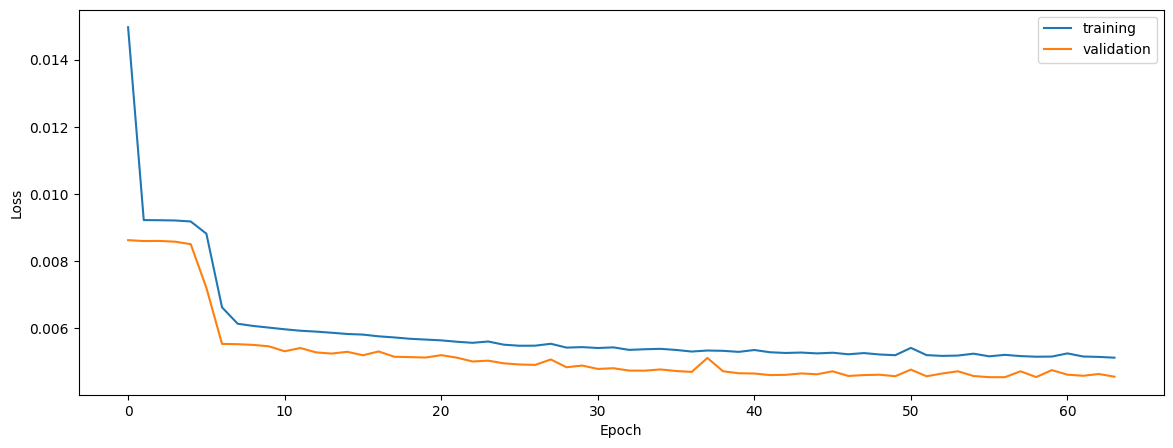

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6655127704098066
0.6884133649928748
0.6705708855760238


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.6655127704098066
0.6884133649928748
0.6705708855760238


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.6594955792075977
0.6890074246725799
0.662164604661348


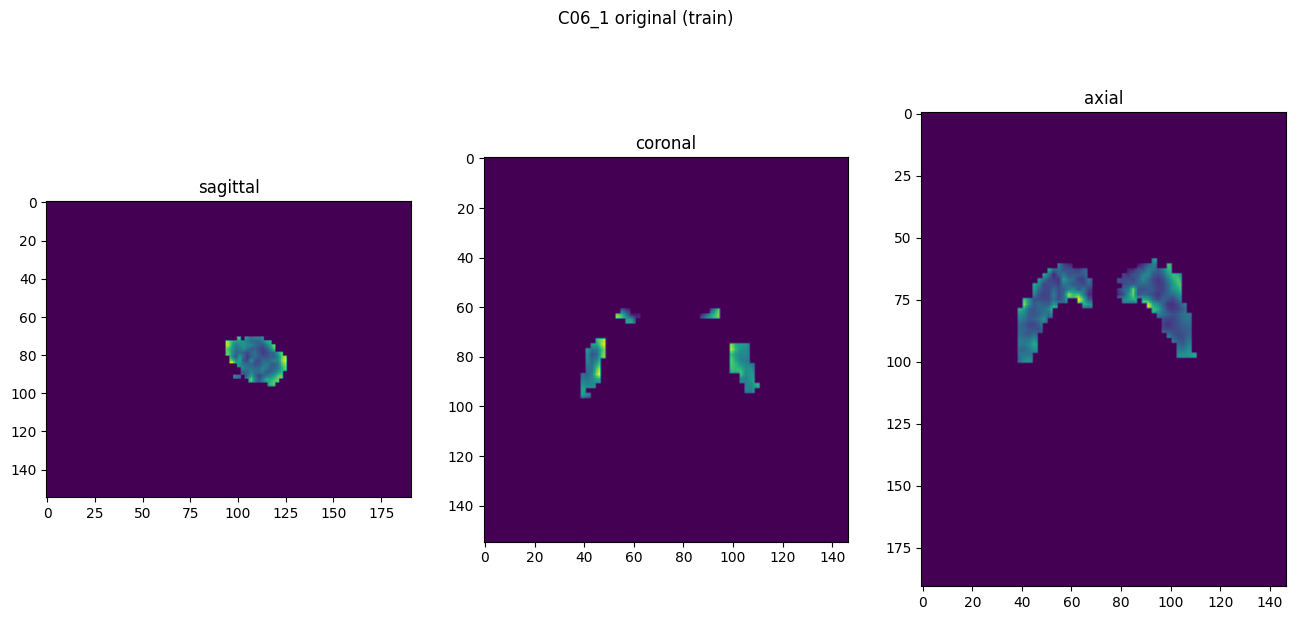

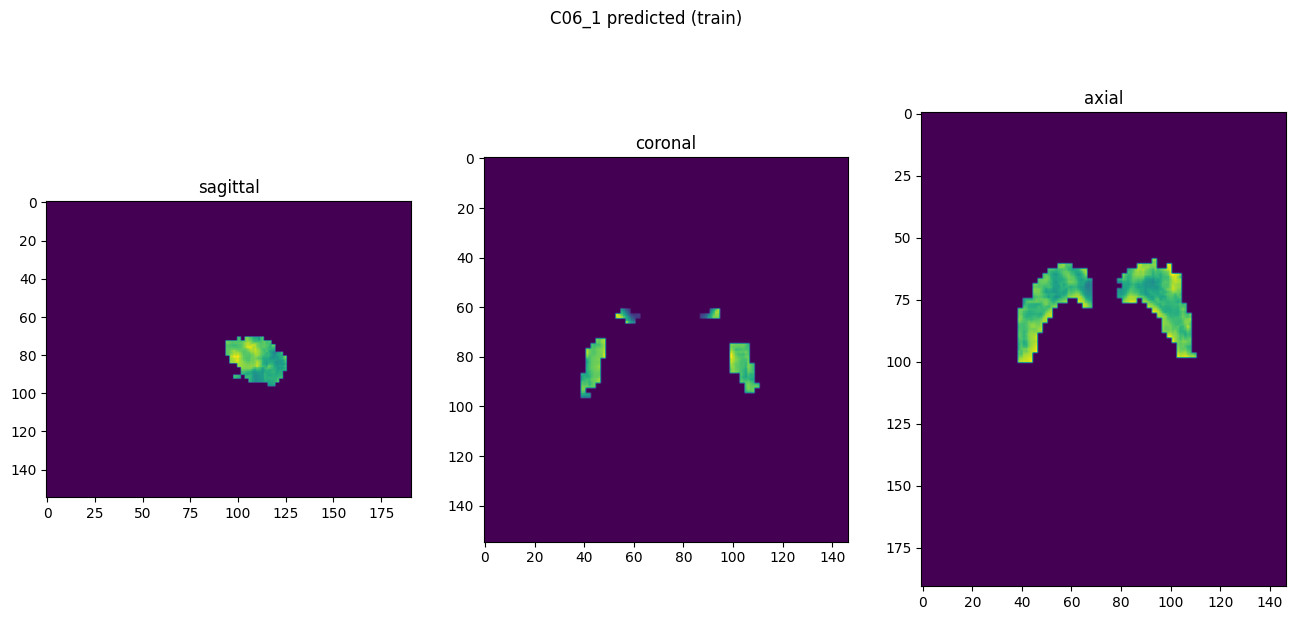

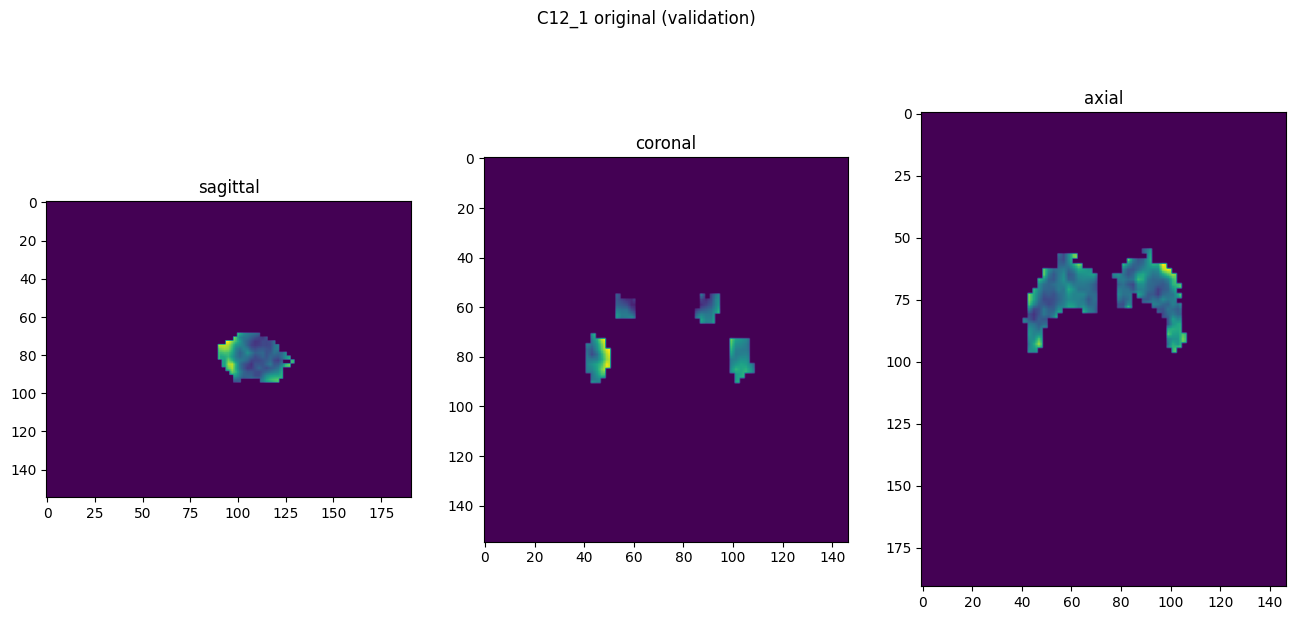

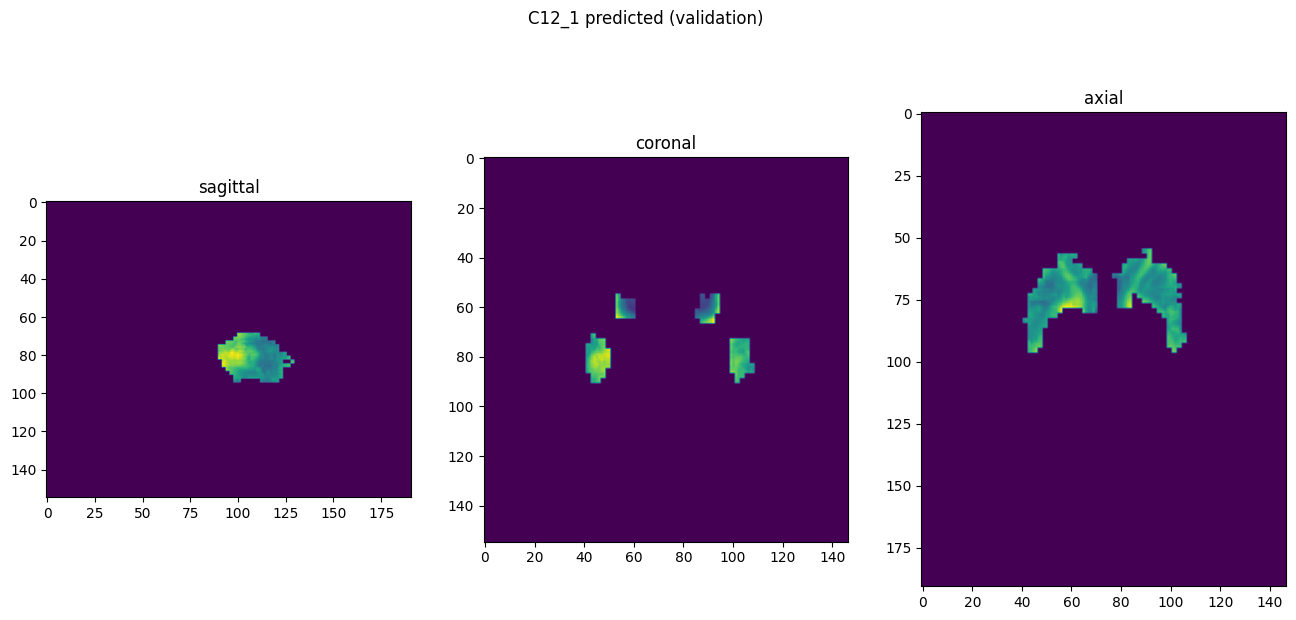

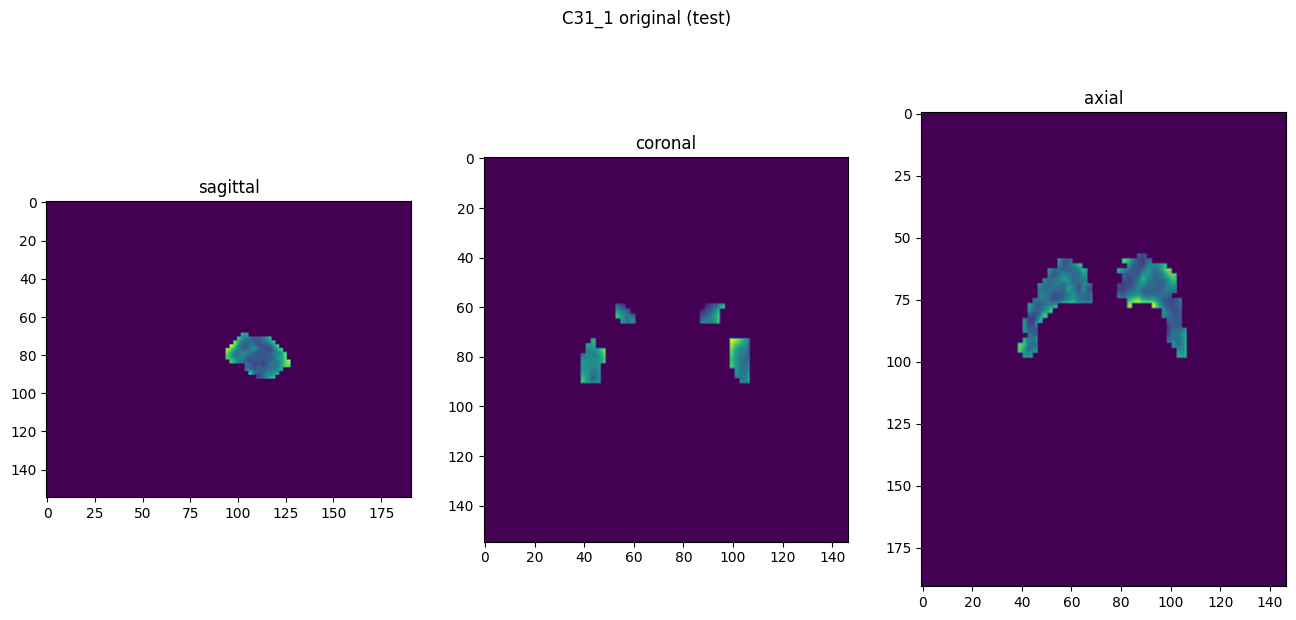

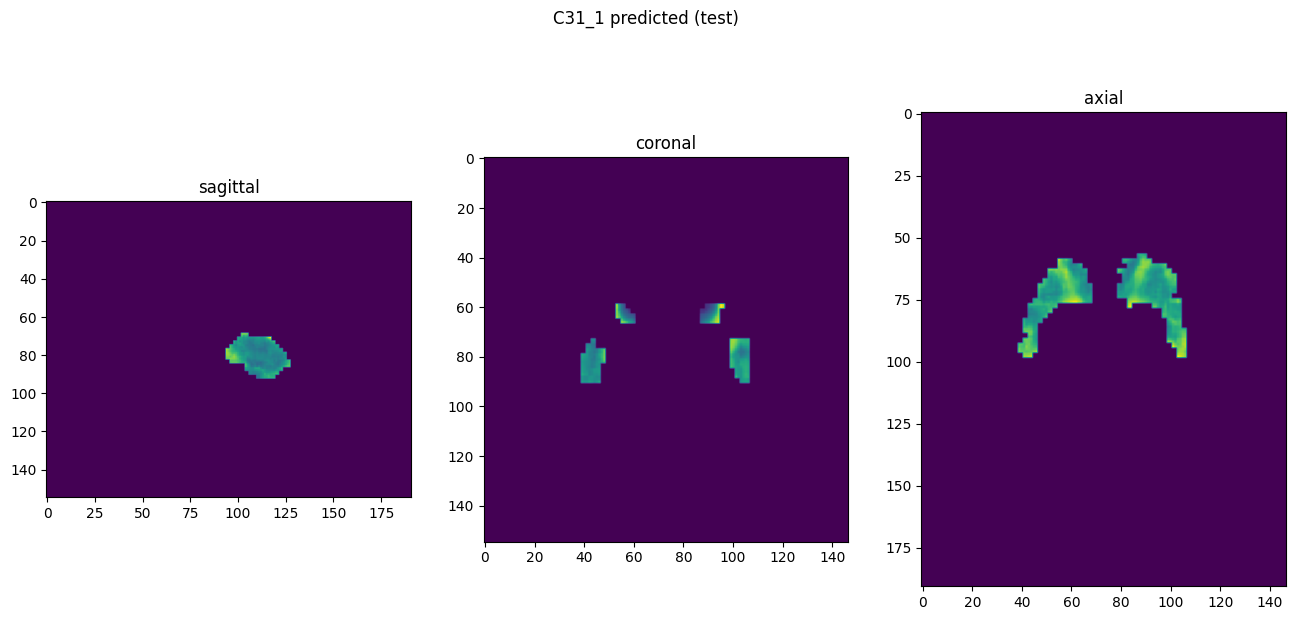

In [10]:
showResults(model, gen, threshold=None, background=False)